# Parameterizing MTE normalization constants

**Global** normalization values according to Brown & Sibly (Chap. 2 MTE Book)

In [1]:
Boltz = 8.62e-5; # Boltzmann constant eV/K 
aE = 0.65; # activation energy eV

## Plant metabolic rates
Any metabolic rate relates to mass following $B = b_{0}.M^{-1/4}e^{\frac{aE}{(Boltz*T)}}$ where $b_{0}$ has an specific value according to taxa and metabolic stage (Savage et al. 2004).
### Parameterizing growth rate with annual biomass production according to Ernest et al. (2003): growth
Annual net primary production (kg/individuals/y) follows the same relationship, where the proportionality constant $b_{growth}$ was verified for different taxonimical groups. The scaling exponent for growth $\approx$ 0.75 (0.759, for plants).

The MTE model $B_{growth} = b_{growth}.M^{0.759}e^{\frac{-aE}{(Boltz*T)}}$ can be re-written as, with temperature correction

$\frac{B_{mort}}{e^{\frac{-aE}{(Boltz*T)}}} = b_{growth}.M^{0.759}$ and

$\log_{10}(Be^{\frac{aE}{(Boltz*T)}}) = \log_{10}(b_{growth}) + 0.759\log_{10}(M)$

To reproduce Ernest et al. 2003:

![title](img/Ernest2003_EcoLettters.png)

For plants, the growing season average temperature was 20°C.

Temperature independent (temperature-correted in MTE chap. 2) normalization constant for plants is 10.15.

In [2]:
using Plots 

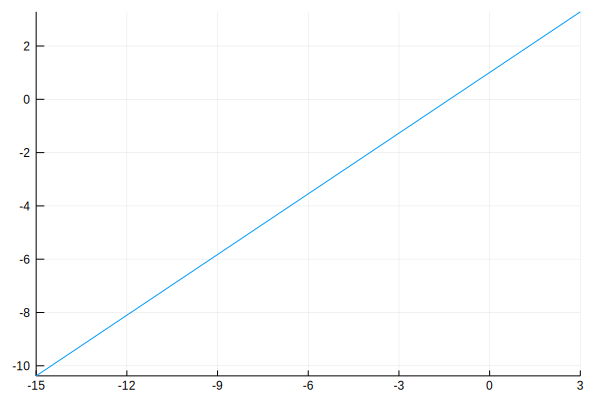

In [12]:
gb0 = 10.15; # growth normalization constant
logM = collect(-15:1:3);
logBeEkt = log10(gb0)+ 0.759.*logM;
plot(logM,logBeEkt,label = "")
ylabel!("Log10(temperature corrected\nindividual biomass produciton)")
xlabel!("Log10(mass)")

The range of $log_{10}(B.e^\frac{E}{kT})$ does not verify Ernest et al.'s if the normalization constant $b_{growth}$ is taken to be 10.15. 

If its log is 10.15, though:

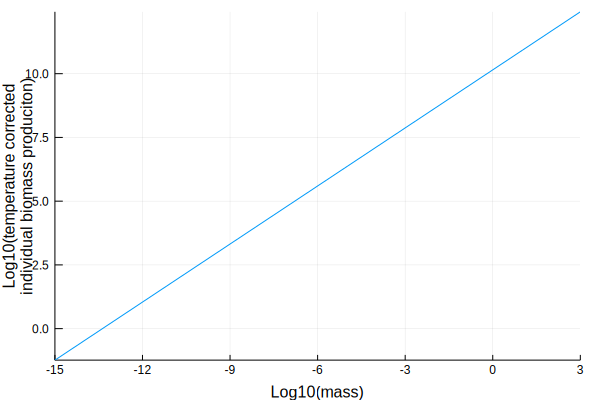

In [4]:
logM = collect(-15:1:3);
loggb0 = 10.15
logBeEkt = loggb0 + 0.759.*logM;
plot(logM,logBeEkt, label ="")
ylabel!("Log10(temperature corrected\nindividual biomass produciton)")
xlabel!("Log10(mass)")

Therefore, the normalization constant is actually $10^{10.15} = 1.4125375446227554e10$.

Since this is the **annual** growth rate, and it must be down-scaled for **weekly** growth rate:

* Unity check

$\frac{kg}{individuals.year} = b_{0}.kg.e^{\frac{eV}{eV.K^{-1}*K}}$

$b_{0}$ is in $individuals^{-1}.year^{-1}$ and biomass unity does not matter.

* Annual to weekly rate transformation check

If **yearly constant** growth, $b_{0} = \frac{b_{0}}{52}$

In [24]:
gb0 = 10^(10.15);
T = 20; #Ernest's mean temperature
gb0_w = gb0/52;
mass_i = 10;
B = 0.0;
for w in 1:52
    prod = gb0_w*mass_i^0.759*exp(-aE/(Boltz*(T+273)))
    B += prod
    mass_i += prod
end
println("Total biomass production: ", B, " and final mass ", mass_i)

Total biomass produciton: 0.5505225256999923 and final mass 10.550522525699986


If growth stops during winter (weeks 51 - 12),  $b_{0} = \frac{b_{0}}{39}$

In [28]:
gb0 = 10^(10.15);
T = 20; #Ernest's mean temperature
gb0_w = gb0/39;
mass_i = 10;
B = 0.0;
for w in 1:39
    prod = gb0_w*mass_i^0.759*exp(-aE/(Boltz*(T+273)))
    B += prod
    mass_i += prod
end
println("Total biomass production: ", B, " and final mass ", mass_i)

Total biomass production: 0.550449313160206 and final mass 10.550449313160206


https://www.biogeosciences-discuss.net/bg-2010-210/ relates 750+-150gC/ year

Verifying Ernest et al. 2003: 

$\log_{10}(Be^{\frac{aE}{(Boltz*T)}}) = \log_{10}(b_{growth}) + 0.759\log_{10}(M)$

### Parameterizing mortality rate 
Death depends on size and age. Size affects the growth rate $Z$ and both affect the probability of mortality $p$ (further detail below).

- Minimal plant size: 1g, which means that a plant weighing 1g should have 99% chance of dying.
- Maximal age: 52 weeks old plants (annual) should have 99% chance of dying.

Therefore:

$Z = b_{mort}.M^{-1/4}e^{\frac{-aE}{(Boltz*T)}}$

For 1g biomass and 20°C temperature, Z should be 1 (individual/(individual x year)). For that, the normalization constant must be:

$b_{mort} = \frac{1}{1^{-1/4}e^{\frac{-aE}{(Boltz*20)}}}$

In [5]:
mb0 = 1/(1^(-1/4)*exp(-aE/(Boltz*(20+273))))


1.5029220413821088e11

$b_{mort}$ for plants should be **1.5e11**, then.

#### Rate to probability transformation 

https://www.quora.com/What-is-the-intuition-for-the-conversion-between-rate-and-probability

Probabilities can be obtained fromrates via the transformation $p = 1-e^{-rt}$, where $r$ is the rate of interest and $t$ is the time unit. In this case, $r$ is the mortality rate and $t$ is the individuals age. 

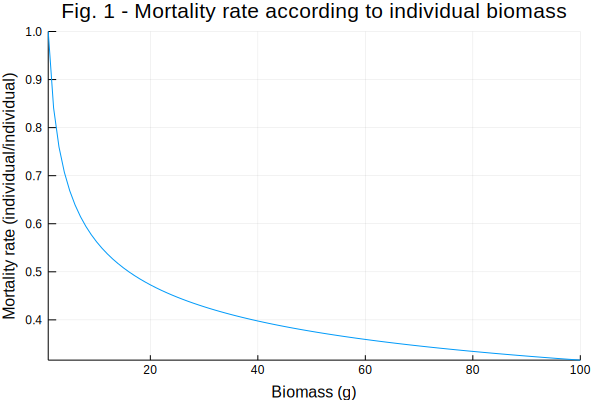

In [6]:
# testing 5.522 as normalization constant capable of generating the proper death probability
# Probability of death x biomass: smaller organisms have higher probability, with 1g having \approx 1
mass_range = collect(1:1:100);
Z = mb0.*mass_range.^(-1/4)*exp(-aE/(Boltz*(273+20)));
plot(mass_range,Z, xlabel = "Biomass (g)", ylabel = "Mortality rate (individual/individual)", label = "")
title!("Fig. 1 - Mortality rate according to individual biomass")

In [7]:
Z[100]

0.316227766016838

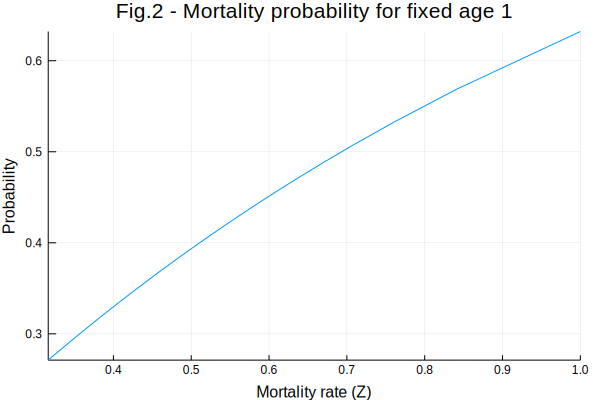

In [8]:
age = 1;
probs = 1 - exp.(-Z*age);
plot(Z,probs, xlabel = "Mortality rate (Z)", ylabel = "Probability", label = "")
title!("Fig.2 - Mortality probability for fixed age 1")

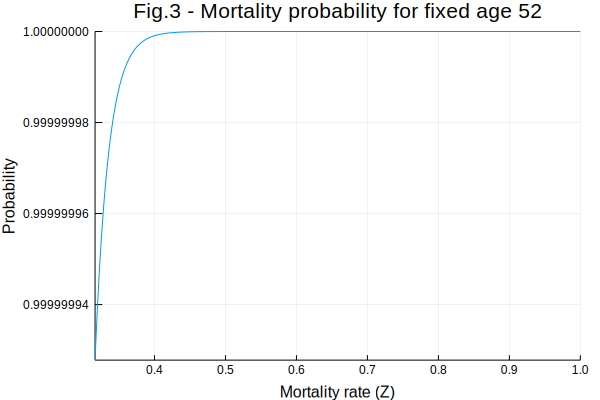

In [9]:
age = 52; # mortality probability should be 1
probs = 1 - exp.(-Z*age);
plot(Z,probs, xlabel = "Mortality rate (Z)", ylabel = "Probability", label = "")
title!("Fig.3 - Mortality probability for fixed age 52")

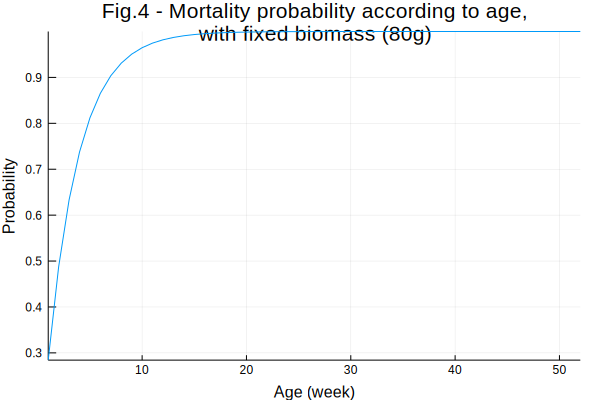

In [10]:
age = collect(1:1:52); # mortality probability should be ~0 for t=1 and ~1 for t=52
mass = 80;
Z = mb0*mass^(-1/4)*exp(-aE/(Boltz*(273+20)));
probs = 1 - exp.(-Z.*age);
plot(age,probs, xlabel = "Age (week)", ylabel = "Probability", label = "")
title!("Fig.4 - Mortality probability according to age,\nwith fixed biomass (80g)")

Even though the individual's age should weight the mortality probability (Fig. 3), having a normalization constant parameterized at individual level and close to 1:1 rate to probability transformation (Fig. 2) should be enough to give a realistic mortality function...

**Or it is possible to ~~hack~~ scale the probability ** 

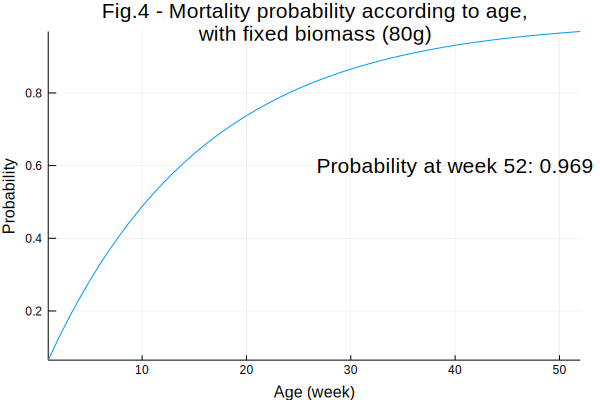

In [11]:
age = collect(1:1:52); # mortality probability should be ~0 for t=1 and ~1 for t=52
mass = 80;
Z = mb0*mass^(-1/4)*exp(-aE/(Boltz*(273+20)));
probs = 1 - exp.(-Z.*age./5);
plot(age,probs, xlabel = "Age (week)", ylabel = "Probability", label = "")
title!("Fig.4 - Mortality probability according to age,\nwith fixed biomass (80g)")
annotate!(40,0.6,string("Probability at week 52: ", round(probs[52],3)))

The rate-probability function will be $p=1-e^{-b_{mort}.t/5}$

### Parameterizing offspring number

Ernest et al. 2003: net production is both biomass  and reproduction